# Plan and Solve Agent

We define a plan and solve generative AI agent via langgraph for problem solving. The idea is that an initial LLM generates a plan to solve the user's query. This plan is passed to an agent, which, equipped with tools, tries to solve each step one by one. Once the last step has been executed, an empty plan is returned which triggers the end step in the graph. The setup is a slightly tweaked version of langgraph's plan and solve tutorial https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/ 

In [ ]:
import os
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI

api_key = os.environ.get("GOOGLE_API_KEY")
api_key_tavily = os.environ.get("TAVILY_API_KEY")
genai.configure(api_key=api_key)

os.environ["GOOGLE_API_KEY"]  = api_key
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature = 0.5)

We will only use a single search tool as our tools. Tavily or DuckDuckGo both work, though Tavily's result in general being more on point.

In [3]:
from langchain.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import create_react_agent

#from langchain.tools import DuckDuckGoSearchResults
#search = DuckDuckGoSearchResults()

search = TavilySearchResults()
tools = [search]
agent_executor = create_react_agent(llm, tools, prompt = "You are a helpful assistant. You MUST be 100 percent sure about your answer, otherwise use your tools.")

In [4]:
agent_executor.invoke({"messages" : [("user","Who is the current US president?")]})

{'messages': [HumanMessage(content='Who is the current US president?', additional_kwargs={}, response_metadata={}, id='51ded47e-9081-4afa-bef6-be5232701900'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "current US president"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--d4c1938e-8cc1-4280-9528-8fdeeb3e9af8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current US president'}, 'id': '3102e68d-3ad3-418f-8806-43f89933d214', 'type': 'tool_call'}], usage_metadata={'input_tokens': 80, 'output_tokens': 12, 'total_tokens': 92, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{"title": "President of the United States - Ballotpedia", "url": "https://ballotpedia.org/President_of_the_United_States", "content": "The **President of the United States** (POTUS) is the head of the Un

TypedDict definition with annotated state tracking.

In [ ]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str # input query from user
    plan: List[str] # the plan which gets initialized once and then updated after every step
    past_steps: Annotated[List[Tuple], operator.add] # keep track of both past tasks and answer to mantain context
    answers : Annotated[List[str], operator.add] # list containig all giving answered
    response : str # final output

## Plan and replaner step

In [6]:
from pydantic import BaseModel, Field
from typing import List


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(description="different steps to follow, should be in sorted order")

In [7]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """For the given objective, come up with a step-by-step plan, even if some steps may be hard to execute. 
Do NOT respond with an apology or refusal. Make assumptions if needed, but return steps regardless."""
    ),
    ("placeholder", "{messages}")
])
planner = planner_prompt | llm.with_structured_output(Plan)

In [8]:
planner.invoke(
    {
        "messages": [
            ("user", "Who is the current US president and what is his age?")
        ]
    }
)

Plan(steps=['Find the current US president.', "Find the current US president's age."])

In [9]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. Once you have done every step, return an empty list.
"""
)


replanner = replanner_prompt | llm.with_structured_output(Plan)


## Final reponse step

In [10]:
class Response(BaseModel):
    """Response to user."""

    response: str = Field(description="Final answer to the user.")

final_response_prompt = ChatPromptTemplate.from_template(
    """
Your objective was this:
{input}

Your original plan was this:
{plan}

You have answered the steps with the following responses:
{answers}

Using all these information, provide a final answer to the user.
"""
)

finalizer = final_response_prompt | llm.with_structured_output(Response)

## Functions defining the graph's nodes

In [11]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}.
Please make sure the result is up-to-date as of 2025. Prefer official or reliable sources with publication dates."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )

    response = agent_response["messages"][-1].content
    return {
        "past_steps": [(task, response)],
        "answers": [response]
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    return {"plan": output.steps}


async def should_end(state: PlanExecute) -> Literal["agent", "final_response"]:
    if not state["plan"]:  # Plan exhausted, we're done
        return "final_response"
    else:
        return "agent"
    
async def response(state: PlanExecute):
    final_answer = await finalizer.ainvoke(state)
    return {"response" : final_answer.response}


## Initiate the graph

In [12]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_node("final_response", response)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

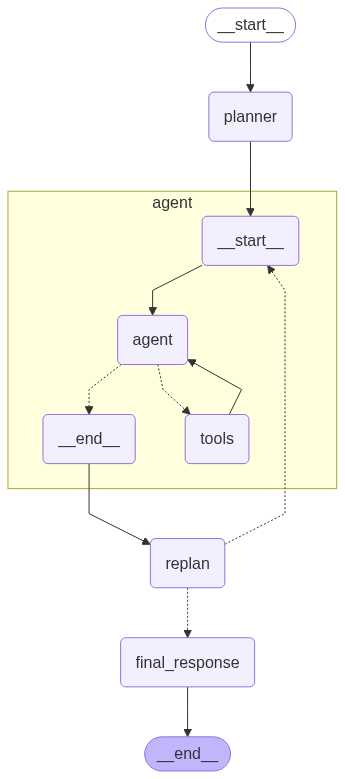

In [13]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## test

In [14]:
config = {"recursion_limit": 20}
hard_question = "Find out who the current US president and UK prime minister are. Then summarize each of their economic policy goals based on official statements or recent news."
inputs = {"input": hard_question}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(k, v)

planner {'plan': ['Identify the current US president and UK prime minister.', 'Research the economic policy goals of the US president based on official statements or recent news.', 'Research the economic policy goals of the UK prime minister based on official statements or recent news.', 'Summarize the economic policy goals of the US president and the UK prime minister.']}
agent {'past_steps': [('Identify the current US president and UK prime minister.', 'Based on the search results, as of May 2025:\n\n*   The US President is Donald Trump.\n*   The UK Prime Minister is Keir Starmer.')], 'answers': ['Based on the search results, as of May 2025:\n\n*   The US President is Donald Trump.\n*   The UK Prime Minister is Keir Starmer.']}
replan {'plan': ['Research the economic policy goals of Donald Trump based on official statements or recent news.', 'Research the economic policy goals of Keir Starmer based on official statements or recent news.', 'Summarize the economic policy goals of Donal